### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

import pickle
import warnings
warnings.filterwarnings("ignore")

Noting from 02.Exploratory_Data_Analysis.ipynb, we saw that after covid started, there was a massive decline in the demand for taxis. This is why we decided to use precovid cases and covid cases to forecast different boroughs.

### Read in Dataset

In [2]:
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))
bronx_df = pickle.load(open('./data/final_cleaned_data/bronx_cleaned_data.pkl','rb'))
brooklyn_df = pickle.load(open('./data/final_cleaned_data/brooklyn_cleaned_data.pkl','rb'))
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
staten_df = pickle.load(open('./data/final_cleaned_data/staten_cleaned_data.pkl','rb'))

In [3]:
# Placeholder for RMSE scores;
placeholder_manhattan = {}
placeholder_queens = {}
placeholder_bronx = {}
placeholder_brooklyn = {}
placeholder_staten = {}


### Let's separate before lockdown and after lockdown in different boroughs due to covid.

In [4]:
# Manhattan
man_precovid_df = manhattan_df[:'2020-03-21']
man_covid_df = manhattan_df['2020-03-22':]

#Queens
queens_precovid_df = queens_df[:'2020-03-21']
queens_covid_df = queens_df['2020-03-21':]

# Brooklyn
brooklyn_precovid_df = brooklyn_df[:'2020-03-21']
brooklyn_covid_df = brooklyn_df['2020-03-21':]

# Bronx
bronx_precovid_df = bronx_df[:'2020-03-21']
bronx_covid_df = bronx_df['2020-03-21':]

# Staten Island
staten_precovid_df = staten_df[:'2020-03-21']
staten_covid_df = staten_df['2020-03-21':]

##### Splitting into train and test sets for Manhattan:

In [5]:
## PRECOVID TRAIN(70%), TEST SET(30%)
X = man_precovid_df.values
size = int(len(X) * 0.70)
man_precovid_train, man_precovid_test  = man_precovid_df[:size], man_precovid_df[size:]
queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
brooklyn_precovid_train, brooklyn_precovid_test  = brooklyn_precovid_df[:size], brooklyn_precovid_df[size:]
bronx_precovid_train, bronx_precovid_test  = bronx_precovid_df[:size], bronx_precovid_df[size:]
staten_precovid_train, staten_precovid_test  = staten_precovid_df[:size], staten_precovid_df[size:]

## COVID  (70%), TEST (30%)
man_covid_train, man_covid_test = man_covid_df[:size], man_covid_df[size:]
queens_covid_train, queens_covid_test = queens_covid_df[:size], queens_covid_df[size:]
brooklyn_covid_train, brooklyn_covid_test = brooklyn_covid_df[:size], brooklyn_covid_df[size:]
bronx_covid_train, bronx_covid_test = bronx_covid_df[:size], bronx_covid_df[size:]
staten_covid_train, staten_covid_test = staten_covid_df[:size], staten_covid_df[size:]

# PRE-COVID: MANHATTAN

### Naive Forecast: Manhattan

Forecast the net day by taking last day value and estimate same value for the next day: Assuming next expected point is equal to the last observed point


In [6]:
man_precovid_train.index

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 01:00:00',
               '2019-06-01 02:00:00', '2019-06-01 03:00:00',
               '2019-06-01 04:00:00', '2019-06-01 05:00:00',
               '2019-06-01 06:00:00', '2019-06-01 07:00:00',
               '2019-06-01 08:00:00', '2019-06-01 09:00:00',
               ...
               '2019-12-24 02:00:00', '2019-12-24 03:00:00',
               '2019-12-24 04:00:00', '2019-12-24 05:00:00',
               '2019-12-24 06:00:00', '2019-12-24 07:00:00',
               '2019-12-24 08:00:00', '2019-12-24 09:00:00',
               '2019-12-24 10:00:00', '2019-12-24 11:00:00'],
              dtype='datetime64[ns]', name='pickup_time', length=4956, freq='H')

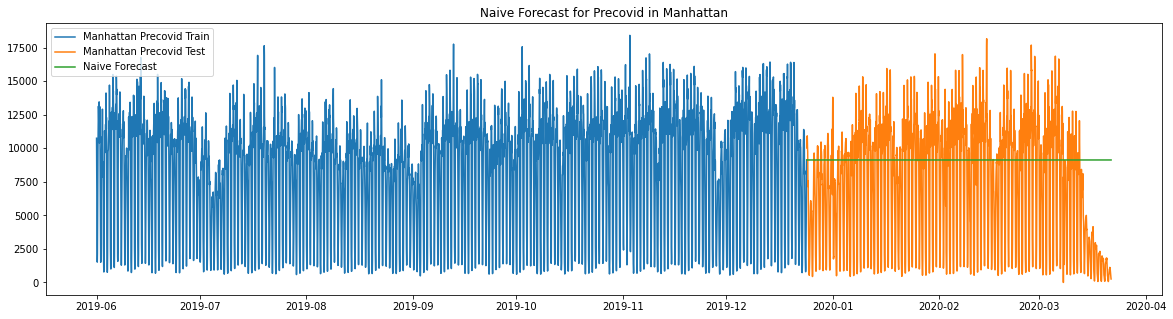

In [7]:
#dd= np.asarray(train_.count)
y_hat = man_precovid_test.copy()
y_hat['naive'] = man_precovid_train['count'][len(man_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(man_precovid_train.index, man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test.index,man_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Manhattan Precovid Train', 'Manhattan Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Manhattan")
plt.show()

In [8]:
rmse_naive = math.sqrt(mean_squared_error(man_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_manhattan['naive_forecast_baseline'] = rmse_naive
placeholder_manhattan

rmse_naive: 4805.149712683199


{'naive_forecast_baseline': 4805.149712683199}

Using Naive Forecasting, we got a RMSE score of 4805.15 which means that our model fits with 4805 error. Naive Forecast Model is not ideal because it's only using the last value of my train to predict on the rest 

#### Baseline: Rolling Moving Average: Manhattan

Forecast the next hour by taking the hour before and estimate same value for the next hour: Assuming next expected point is equal to the last observed point

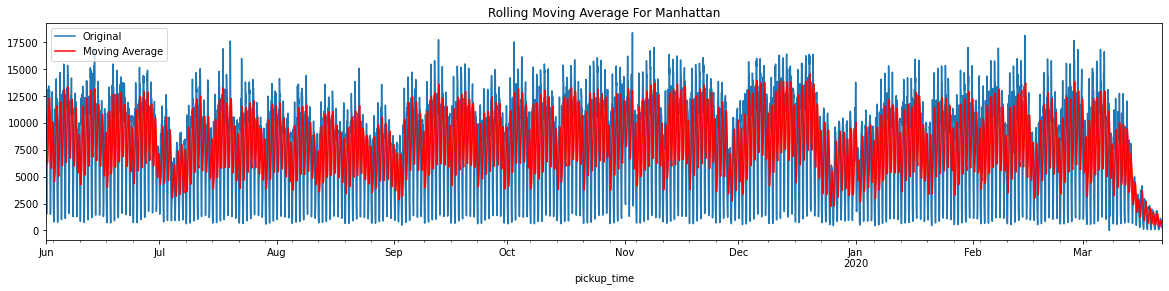

In [32]:
# Tail-rolling average transform
rolling = man_precovid_df.rolling(window=12)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
man_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Manhattan')
plt.show()

We put the window = 7 for size of the moving window. 

In [10]:
series = man_precovid_df
# prepare situation
X = series.values
window = 7
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)



In [11]:
print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')


Test MSE: 17067390.709648937, RMSE:4131.2698664755535


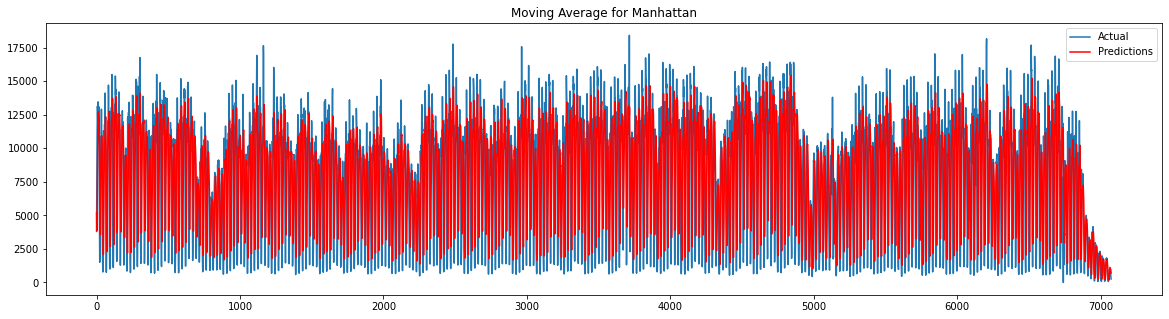

In [12]:
fig, ax =  plt.subplots(figsize=(20,5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('Moving Average for Manhattan')
plt.legend(['Actual', 'Predictions'])
plt.show()

It's not very clear from the graph above so let's look at the zoomed graph of first 100 hours

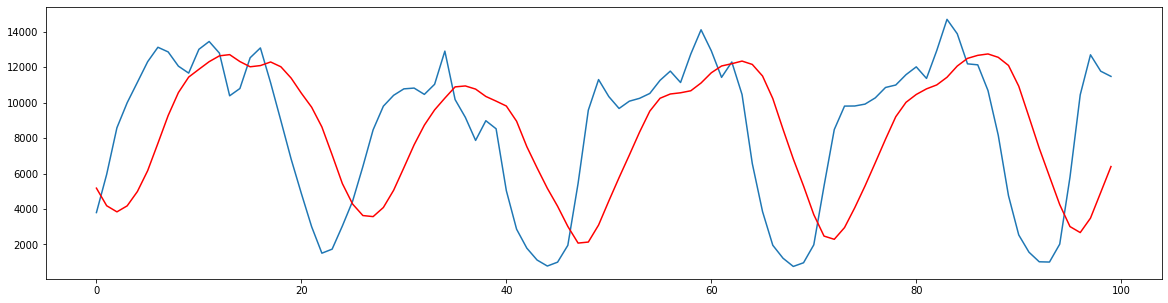

In [13]:
fig, ax =  plt.subplots(figsize=(20,5))
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red') #first 100th hour
plt.show()

Looking at the first 100 hour,  we can see there is some lag. 

I will instantiate the placeholder object to keep all the RMSE into one place

In [14]:
placeholder_manhattan['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_manhattan

{'naive_forecast_baseline': 4805.149712683199,
 'moving_average_baseline': 4131.2698664755535}

### Holt's Linear Trend Method: Manhattan

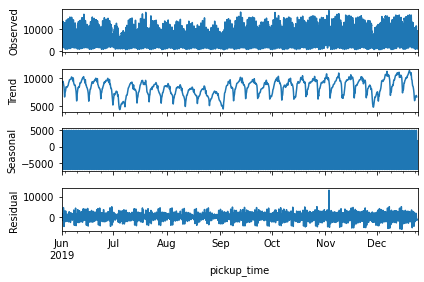

In [15]:
sm.tsa.seasonal_decompose(man_precovid_train['count']).plot()
result = sm.tsa.stattools.adfuller(man_precovid_train['count'])

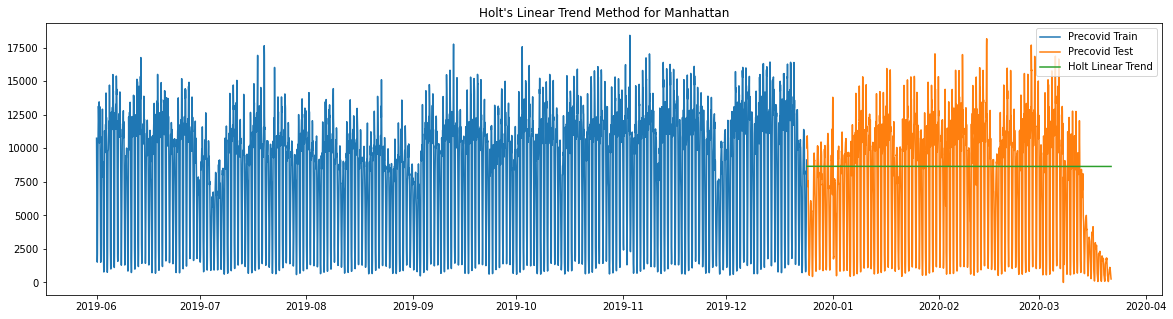

In [16]:
y_hat_avg = man_precovid_test.copy()

fit1 = Holt(np.asarray(man_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit1.forecast(len(man_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Manhattan')
plt.show()

In [17]:
rmse_holt_linear = np.sqrt(np.mean(fit1.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_manhattan['rmse_holt_linear'] = rmse_holt_linear

Holt Linear RMSE:  2058.2126193852323


In [18]:
placeholder_manhattan

{'naive_forecast_baseline': 4805.149712683199,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2058.2126193852323}

### Holt Winter Model: Manhattan

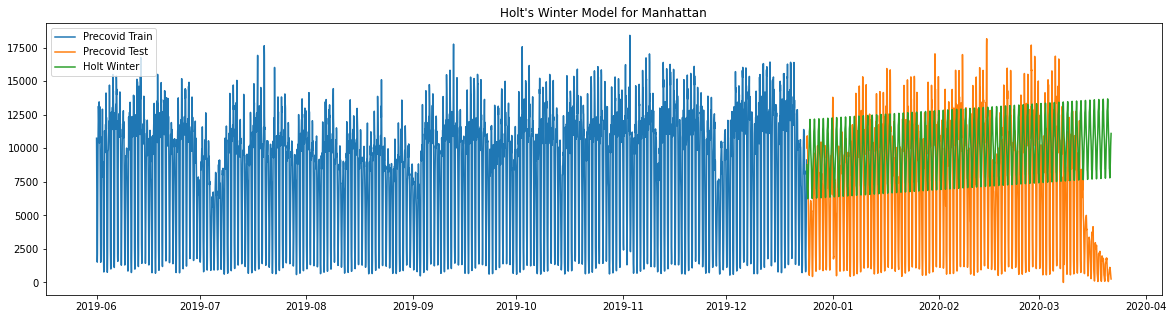

In [19]:
y_hat_avg = man_precovid_test.copy()
fit1 = ExponentialSmoothing(np.asarray(man_precovid_train['count']) ,seasonal_periods=31 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(man_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Manhattan')
plt.show()

In [20]:
rmse_holt_winter= np.sqrt(np.mean(fit1.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_manhattan['rmse_holt_winter'] = rmse_holt_winter

Holt Winter RMSE:  1714.7887920197145


In [21]:
placeholder_manhattan

{'naive_forecast_baseline': 4805.149712683199,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2058.2126193852323,
 'rmse_holt_winter': 1714.7887920197145}

# Precovid: Queens

### Naive Forecast: Queens

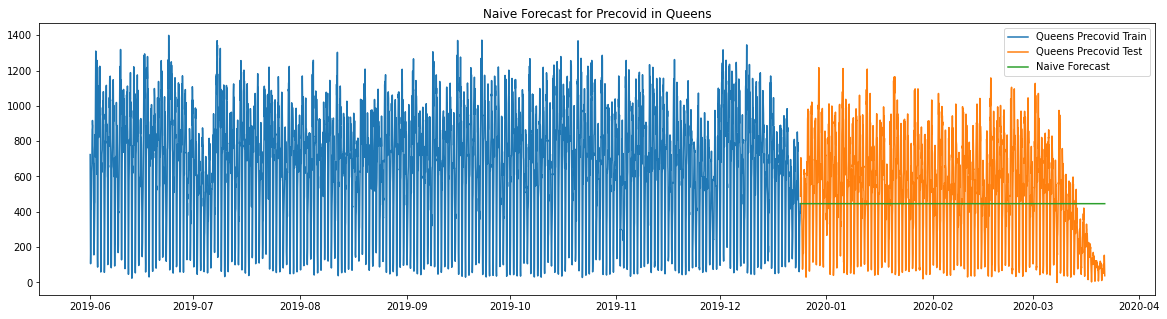

446

In [34]:
#dd= np.asarray(train_.count)
y_hat = queens_precovid_test.copy()
y_hat['naive'] = queens_precovid_train['count'][len(queens_precovid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(queens_precovid_train.index, queens_precovid_train['count'], label='Train')
plt.plot(queens_precovid_test.index,queens_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Queens Precovid Train', 'Queens Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid in Queens")
plt.show()
queens_precovid_train['count'][len(queens_precovid_train['count'])-1]

In [23]:
rmse_naive = math.sqrt(mean_squared_error(queens_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_queens['naive_forecast_baseline'] = rmse_naive
placeholder_queens

rmse_naive: 299.0312670637179


{'naive_forecast_baseline': 299.0312670637179}

### Rolling Mean Average: Queens

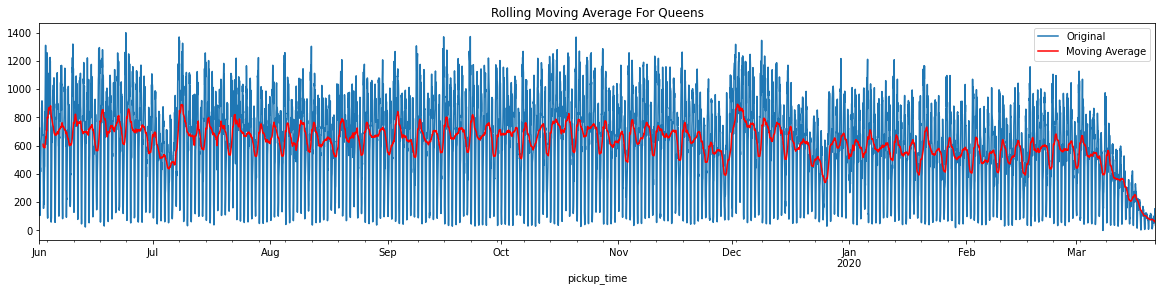

In [35]:
# Tail-rolling average transform
rolling = queens_precovid_df.rolling(window=24)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
queens_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Queens')
plt.show()

In [25]:
series = queens_precovid_df
# prepare situation
X = series.values
window = 7
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_queens['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_queens

Test MSE: 88322.66573084767, RMSE:297.19129484365396


{'naive_forecast_baseline': 299.0312670637179,
 'moving_average_baseline': 297.19129484365396}

## Holt Linear Trend Method: Queens

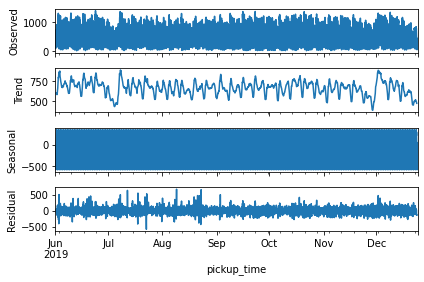

In [26]:
sm.tsa.seasonal_decompose(queens_precovid_train['count']).plot()
result = sm.tsa.stattools.adfuller(queens_precovid_train['count'])

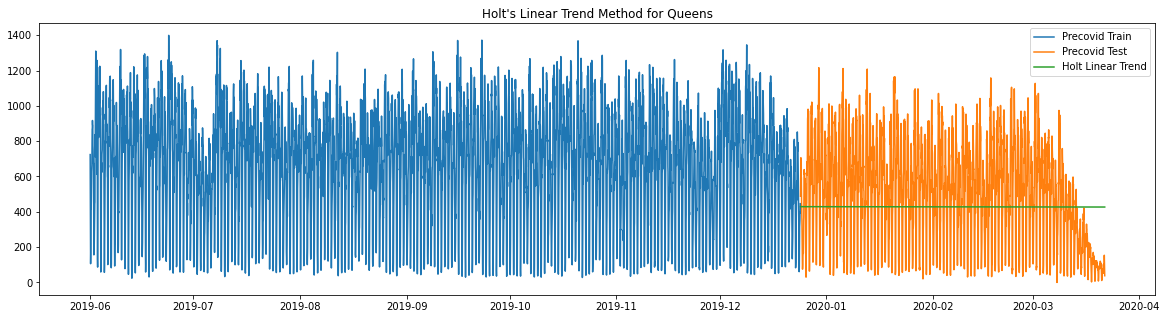

In [27]:
y_hat_avg = queens_precovid_test.copy()

fit_queens = Holt(np.asarray(queens_precovid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_queens.forecast(len(queens_precovid_test))

plt.figure(figsize=(20,5))
plt.plot(queens_precovid_train['count'], label='Train')
plt.plot(queens_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Queens')
plt.show()

In [28]:
rmse_holt_linear = np.sqrt(np.mean(fit_queens.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_queens['rmse_holt_linear'] = rmse_holt_linear
placeholder_queens

Holt Linear RMSE:  168.71272204761075


{'naive_forecast_baseline': 299.0312670637179,
 'moving_average_baseline': 297.19129484365396,
 'rmse_holt_linear': 168.71272204761075}

## Holt Winter Method: Queens

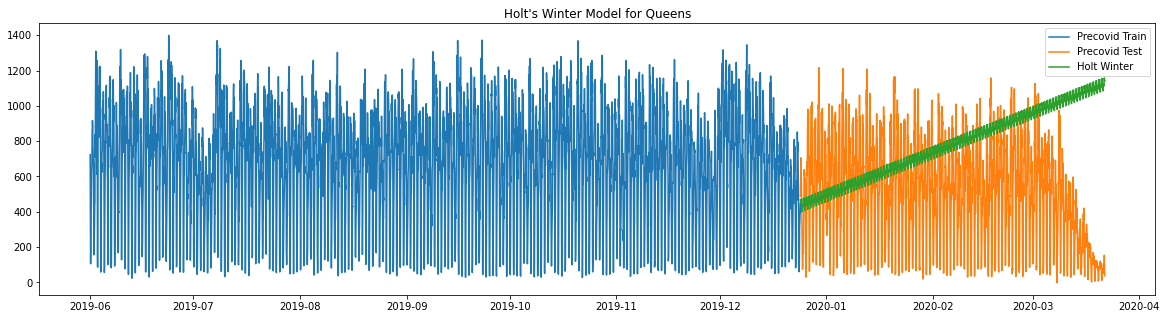

In [29]:
y_hat_avg = queens_precovid_test.copy()
fit_winter_queens = ExponentialSmoothing(np.asarray(queens_precovid_train['count']) ,seasonal_periods=20,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_queens.forecast(len(queens_precovid_test))
plt.figure(figsize=(20,5))
plt.plot(queens_precovid_train['count'], label='Train')
plt.plot(queens_precovid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Precovid Train', 'Precovid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Queens')
plt.show()

In [30]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_queens.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_queens['rmse_holt_winter'] = rmse_holt_winter
placeholder_queens

Holt Winter RMSE:  156.63011060104978


{'naive_forecast_baseline': 299.0312670637179,
 'moving_average_baseline': 297.19129484365396,
 'rmse_holt_linear': 168.71272204761075,
 'rmse_holt_winter': 156.63011060104978}

Compared to Manhattan, there are less pickups overall but the graphs do look similar.